In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]

gene_subset = 'polya'

biosamp_name_map = '../'+expand(config['ref']['biosamp_map'])[0]

cage_meta = '../'+expand(config['cage']['meta'], species='human')[0]
rampage_meta = '../'+expand(config['rampage']['meta'], species='human')[0]

In [4]:
def convert_encode_desc(df, col):
    """
    Convert encode desc. of a sample into something more parseable
    """
    df[col] = df[col].str.lower()
    df[col] = df[col].str.replace(', ', '_')
    df[col] = df[col].str.replace(' ', '_')
    df[col] = df[col].str.replace('-', '_')
    
    return df

In [5]:
def get_sample_names_from_dl_meta(meta_file, biosamp_map_file):
    """
    Get a list of samples present from an input ENCODE download file
    """
    df = pd.read_csv(meta_file, sep='\t')    
    df = df[['File accession', 'Experiment accession', 'Biosample term name', 'Biosample type', 'Technical replicate(s)', 'Biological replicate(s)']]
    df['classification'] = 'cell_line'
    df.loc[df['Biosample type']=='tissue', 'classification'] = 'tissue'
    df = convert_encode_desc(df, 'Biosample term name')
    
    # convert hyphenated cell line names
    term_map = pd.read_csv(biosamp_map_file, sep='\t',
                           header=None, names=['eid', 'old_name', 'idk1', 'idk2', 'new_name'])
    term_map = convert_encode_desc(term_map, 'old_name')
    term_map = convert_encode_desc(term_map, 'new_name')
    term_map = term_map[['old_name', 'new_name']]
    term_map.drop_duplicates(inplace=True)
    n1 = len(df.index)
    # print(n1)
    df = df.merge(term_map, how='left', left_on='Biosample term name', right_on='old_name')
    n2 = len(df.index)
    # print(n2)
    if n1 != n2:
        print('Duplicated thingies, check for DE samples')
    df.rename({'Biosample term name': 'sample'}, axis=1, inplace=True)
    df.loc[~df.new_name.isnull(), 'sample'] = df.loc[~df.new_name.isnull(), 'new_name']
    
    return df['sample'].unique().tolist()
    
    

In [6]:
# get the samples that we have in cage and in LR
cage_samples = get_sample_names_from_dl_meta(cage_meta, biosamp_name_map)
rampage_samples = get_sample_names_from_dl_meta(rampage_meta, biosamp_name_map)
tss_samples = set(cage_samples+rampage_samples)
lr_samples = pd.read_csv(lib_meta, sep='\t')['sample'].unique().tolist()
tss_lr_samples = list(set(lr_samples)&set(tss_samples))
tss_lr_samples

['mcf7',
 'h1',
 'k562',
 'huvec',
 'pc3',
 'imr90',
 'pgp1',
 'ocily7',
 'lung',
 'liver',
 'gm12878',
 'hepg2',
 'heart']

Calculating tss TPM values
Subsetting for ['mcf7', 'h1', 'k562', 'huvec', 'pc3', 'imr90', 'pgp1', 'ocily7', 'lung', 'liver', 'gm12878', 'hepg2', 'heart'] samples
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 53019
Applying gene type and novelty subset
Number of tsss reported: 51063
153941
51063
     support  counts
0      Known   43483
1      Novel    4033
2  Supported    3547
14.84% (7580/51063) of tsss are novel
46.79% (3547/7580) of novel tsss are supported



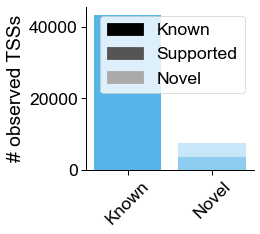

In [13]:
feat = 'tss'
ref_source = ['v29', 'v40']
support_source = ['encode_cage', 'fantom_cage', 'encode_rampage', 'pls']

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = plt.gca()

plot_supported_feats_2(filt_ab=filt_ab,
                     h5=cerberus_h5,
                     feat=feat,
                     ref_sources=ref_source,
                     support_sources=support_source,
                     how=feat,
                     opref='figures/human',
                     gene_subset=gene_subset,
                     min_tpm=1,
                     ax=ax,
                     sample=tss_lr_samples)

plt.subplots_adjust(wspace=0.35)
# plt.savefig(ofile, dpi=500, layout='tight', bbox_inches='tight')